---
# Permutations

In [27]:
from linescanning import (
    utils,
    plotting,
    fitting,
    prf,
)
import nibabel as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import holeresponse as hr
import seaborn as sns
import scipy
opj = os.path.join

import mne
from mne.stats import (
    bonferroni_correction,
    fdr_correction,
    permutation_cluster_1samp_test,
    permutation_t_test,
    ttest_1samp_no_p,
    spatio_temporal_cluster_test
)

excl = [
    "sub-001",
    "sub-003"
]

In [2]:
# parse h5-files
import pickle
data_dir = opj(os.path.dirname(hr.viz._save_figure(None, return_figdir=True)), "data")

n_compartiments = 20
pkl_base = f"h5_parser_ve_nordic_lp31_comp{n_compartiments}_custom_ribbon" # "h5_parser_lowpass" # "h5_parser"
# pkl_base = "h5_parser_lowpass"
h5_pkl = opj(data_dir, f"{pkl_base}.pkl")
overwrite = False
save = True

if not os.path.exists(h5_pkl) or overwrite:
    h5_obj = hr.data.H5Parser(
        h5_files,
        verbose=True,
        compartments=n_compartiments,
        lp_kw={
        "window_length": 31
        },
        lp=True,
        unique_ribbon=True
    )

    if save:
        print(f"Writing object to '{h5_pkl}'")
        with open(h5_pkl, 'wb') as handle:
            pickle.dump(h5_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print(f"Reading from '{h5_pkl}'")
    with open(h5_pkl, 'rb') as handle:
        h5_obj = pickle.load(handle)

Reading from '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/h5_parser_ve_nordic_lp31_comp20_custom_ribbon.pkl'


In [4]:
comp_ep = fitting.Epoch(
    h5_obj.df_comps.groupby(["subject","task","t"]).mean(),
    hr.data.average_tasks(h5_obj.df_onsets),
    TR=0.105,
    interval=[-2,14]
)
comp_df = comp_ep.df_epoch.copy()
comp_df.head()

0         1         2  \
subject task run event_type epoch t                                         
001     SRFb 1   act        0     -2.000000  2.908607  3.469970  2.815047   
                                  -1.894737  3.493843  4.296184  3.360120   
                                  -1.789474  2.713939  3.061268  2.656051   
                                  -1.684211  1.950083  2.289954  1.893438   
                                  -1.578947  2.603303  3.007559  2.535927   

                                                    3         4         5  \
subject task run event_type epoch t                                         
001     SRFb 1   act        0     -2.000000  2.160124  1.435840  0.457233   
                                  -1.894737  2.424055  1.522351  0.746635   
                                  -1.789474  2.250834  1.839077  1.403343   
                                  -1.684211  1.496921  1.178892  1.148649   
                                  -1.578947  2.064294  1.707459  1.771550   

                                                    6         7         8  \
subject task run event_type epoch t                                         
001     SRFb 1   act        0     -2.000000 -0.521373 -1.432306 -2.221424   
                                  -1.894737 -0.029082 -0.850008 -1.752311   
                                  -1.789474  0.967608  0.428028 -0.298477   
                                  -1.684211  1.118407  0.773580 -0.137501   
                                  -1.578947  1.835640  1.562104  0.680839   

                                                    9        10        11  \
subject task run event_type epoch t                                         
001     SRFb 1   act        0     -2.000000 -3.010542 -3.733381 -4.389940   
                                  -1.894737 -2.654615 -3.635912 -4.696202   
                                  -1.789474 -1.024981 -2.117192 -3.575110   
                                  -1.684211 -1.048582 -1.932877 -2.790385   
                                  -1.578947 -0.200427 -1.007451 -1.740234   

                                                   12        13        14  \
subject task run event_type epoch t                                         
001     SRFb 1   act        0     -2.000000 -5.046499 -4.739601 -3.897448   
                                  -1.894737 -5.756493 -5.335234 -4.090892   
                                  -1.789474 -5.033028 -4.669100 -3.293035   
                                  -1.684211 -3.647894 -3.202653 -2.033663   
                                  -1.578947 -2.473017 -2.236254 -1.460853   

                                                   15        16        17  \
subject task run event_type epoch t                                         
001     SRFb 1   act        0     -2.000000 -3.055295 -1.594368  0.035316   
                                  -1.894737 -2.846550 -1.440236  0.010252   
                                  -1.789474 -1.916969 -0.823471  0.192963   
                                  -1.684211 -0.864672 -0.374381 -0.069189   
                                  -1.578947 -0.685452 -0.224018  0.151788   

                                                   18        19  
subject task run event_type epoch t                              
001     SRFb 1   act        0     -2.000000  1.665000  0.268128  
                                  -1.894737  1.460741  0.217465  
                                  -1.789474  1.209397  0.338168  
                                  -1.684211  0.236003 -0.025590  
                                  -1.578947  0.527595  0.205475

In [6]:
excl_expr = [f"subject != {i.split('-')[-1]}" for i in excl]
comp_excl = utils.multiselect_from_df(
    comp_df,
    expression=excl_expr
)
comp_excl.head()

0         1         2  \
subject task run event_type epoch t                                         
002     SRFa 1   act        0     -2.000000  0.330548  0.268282  0.392815   
                                  -1.894737  0.058631  0.069553  0.047710   
                                  -1.789474  0.303030  0.375384  0.230675   
                                  -1.684211  0.470025  0.617771  0.322279   
                                  -1.578947  0.511430  0.550619  0.472241   

                                                    3         4         5  \
subject task run event_type epoch t                                         
002     SRFa 1   act        0     -2.000000  0.517347  0.512048  0.463471   
                                  -1.894737  0.025867  0.138832  0.296734   
                                  -1.789474  0.085966  0.177602  0.348022   
                                  -1.684211  0.026787  0.140161  0.389823   
                                  -1.578947  0.393864  0.415594  0.470693   

                                                    6         7         8  \
subject task run event_type epoch t                                         
002     SRFa 1   act        0     -2.000000  0.429425  0.438974  0.448523   
                                  -1.894737  0.394339  0.311050  0.227761   
                                  -1.789474  0.499961  0.596460  0.692960   
                                  -1.684211  0.572268  0.553058  0.533849   
                                  -1.578947  0.525766  0.580764  0.635761   

                                                    9        10        11  \
subject task run event_type epoch t                                         
002     SRFa 1   act        0     -2.000000 -0.484028 -1.730613 -2.554214   
                                  -1.894737 -0.361067 -1.118407 -1.622622   
                                  -1.789474  0.072243 -0.787545 -1.354800   
                                  -1.684211  0.085216 -0.506558 -0.951100   
                                  -1.578947  0.162879 -0.485964 -0.944479   

                                                   12        13        14  \
subject task run event_type epoch t                                         
002     SRFa 1   act        0     -2.000000 -2.108868 -1.663522 -1.263648   
                                  -1.894737 -1.367456 -1.112291 -0.710535   
                                  -1.789474 -1.044452 -0.734103 -0.591862   
                                  -1.684211 -0.953947 -0.956795 -0.818749   
                                  -1.578947 -0.832012 -0.719545 -0.694687   

                                                   15        16        17  \
subject task run event_type epoch t                                         
002     SRFa 1   act        0     -2.000000 -0.878932 -0.334521  0.688972   
                                  -1.894737 -0.259916  0.284306  1.109335   
                                  -1.789474 -0.505657 -0.211105  0.708482   
                                  -1.684211 -0.633737 -0.282952  0.565157   
                                  -1.578947 -0.699032 -0.503088  0.293726   

                                                   18        19  
subject task run event_type epoch t                              
002     SRFa 1   act        0     -2.000000  1.712466  1.200719  
                                  -1.894737  1.934364  1.521849  
                                  -1.789474  1.628070  1.168276  
                                  -1.684211  1.413266  0.989211  
                                  -1.578947  1.090541  0.692134

In [29]:
sub_avg = comp_excl.groupby(["subject","event_type","t"]).mean()
act_df = utils.select_from_df(sub_avg, expression=f"event_type = act")

sub_ids = utils.get_unique_ids(act_df, id="subject")
arr = []
for i in sub_ids:
    data = utils.select_from_df(act_df, expression=f"subject = {i}").values.T[np.newaxis,...]
    arr.append(data)

arr = np.concatenate(arr, axis=0)
arr.shape

(8, 20, 152)

In [30]:
n_permutations = 1000
threshold_tfce = dict(start=-1, step=0.01)

t_tfce_hat, clusters, p_tfce_hat, H0 = permutation_cluster_1samp_test(
    arr,
    n_jobs=None,
    threshold=threshold_tfce,
    adjacency=None,
    out_type="mask",
    tail=0,
    n_permutations=n_permutations,
    # stat_fun=stat_fun_hat,
    buffer_size=None,
)


stat_fun(H1): min=-7.863108 max=11.317575
Running initial clustering …
Using 1232 thresholds from -1.00 to 11.31 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

[]


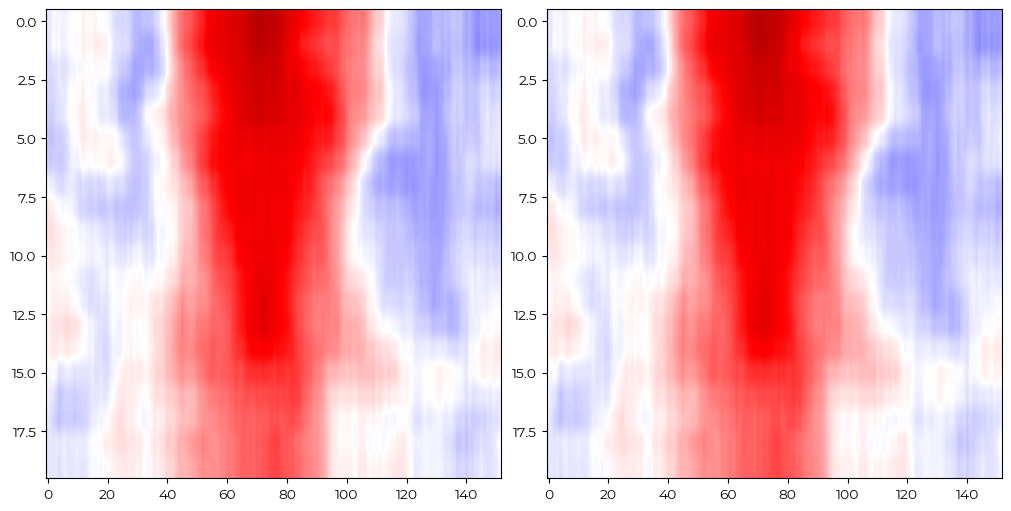

In [32]:
%matplotlib inline
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
ax1.imshow(
    arr.mean(axis=0), 
    aspect="auto",
    cmap="seismic",
    vmin=-2.5,
    vmax=2.5
)


ax2.imshow(
    arr.mean(axis=0), 
    aspect="auto",
    cmap="seismic",
    vmin=-2.5,
    vmax=2.5
)

log10p = -np.log10(p_tfce_hat)
sig = np.zeros_like(clusters[0])

sig_list = list(np.where(p_tfce_hat<0.05)[0])
print(sig_list)
for i in sig_list:
    sig[clusters[i].astype(int)>0] = 1

cm = utils.make_binary_cm("green")
ax2.imshow(sig, aspect="auto", cmap=cm, alpha=0.3)
# plt.show()

In [25]:
print(arr.shape)

(8, 20, 152)


In [35]:
# We are running an F test, so we look at the upper tail
# see also: https://stats.stackexchange.com/a/73993
tail = 1

# We want to set a critical test statistic (here: F), to determine when
# clusters are being formed. Using Scipy's percent point function of the F
# distribution, we can conveniently select a threshold that corresponds to
# some alpha level that we arbitrarily pick.
alpha_cluster_forming = 0.05

# For an F test we need the degrees of freedom for the numerator
# (number of conditions - 1) and the denominator (number of observations
# - number of conditions):
n_conditions = 1
n_observations = arr.shape[-1]
dfn = n_conditions - 1
dfd = n_observations - n_conditions

# Note: we calculate 1 - alpha_cluster_forming to get the critical value
# on the right tail
f_thresh = scipy.stats.f.ppf(1 - alpha_cluster_forming, dfn=dfn, dfd=dfd)

# run the cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    arr,
    n_permutations=1000,
    threshold=f_thresh,
    tail=tail,
    n_jobs=None,
    buffer_size=None,
    adjacency=None,
)
F_obs, clusters, p_values, _ = cluster_stats

stat_fun(H1): min=2.431865 max=28.289619
Running initial clustering …
Found 0 clusters


stat_fun(H1): min=-7.863108 max=11.317575
Running initial clustering …
Found 14 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-7.701234 max=11.280288
Running initial clustering …
Found 13 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-7.863108 max=11.317575
Running initial clustering …
Using 57 thresholds from 0.00 to 11.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-7.701234 max=11.280288
Running initial clustering …
Using 57 thresholds from 0.00 to 11.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.421963 max=6.031474
Running initial clustering …
Found 26 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.384723 max=5.908690
Running initial clustering …
Found 26 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.421963 max=6.031474
Running initial clustering …
Using 31 thresholds from 0.00 to 6.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.384723 max=5.908690
Running initial clustering …
Using 30 thresholds from 0.00 to 5.80 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.467193 max=7.767254
Running initial clustering …
Found 13 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.423690 max=7.667037
Running initial clustering …
Found 13 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.467193 max=7.767254
Running initial clustering …
Using 39 thresholds from 0.00 to 7.60 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.423690 max=7.667037
Running initial clustering …
Using 39 thresholds from 0.00 to 7.60 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

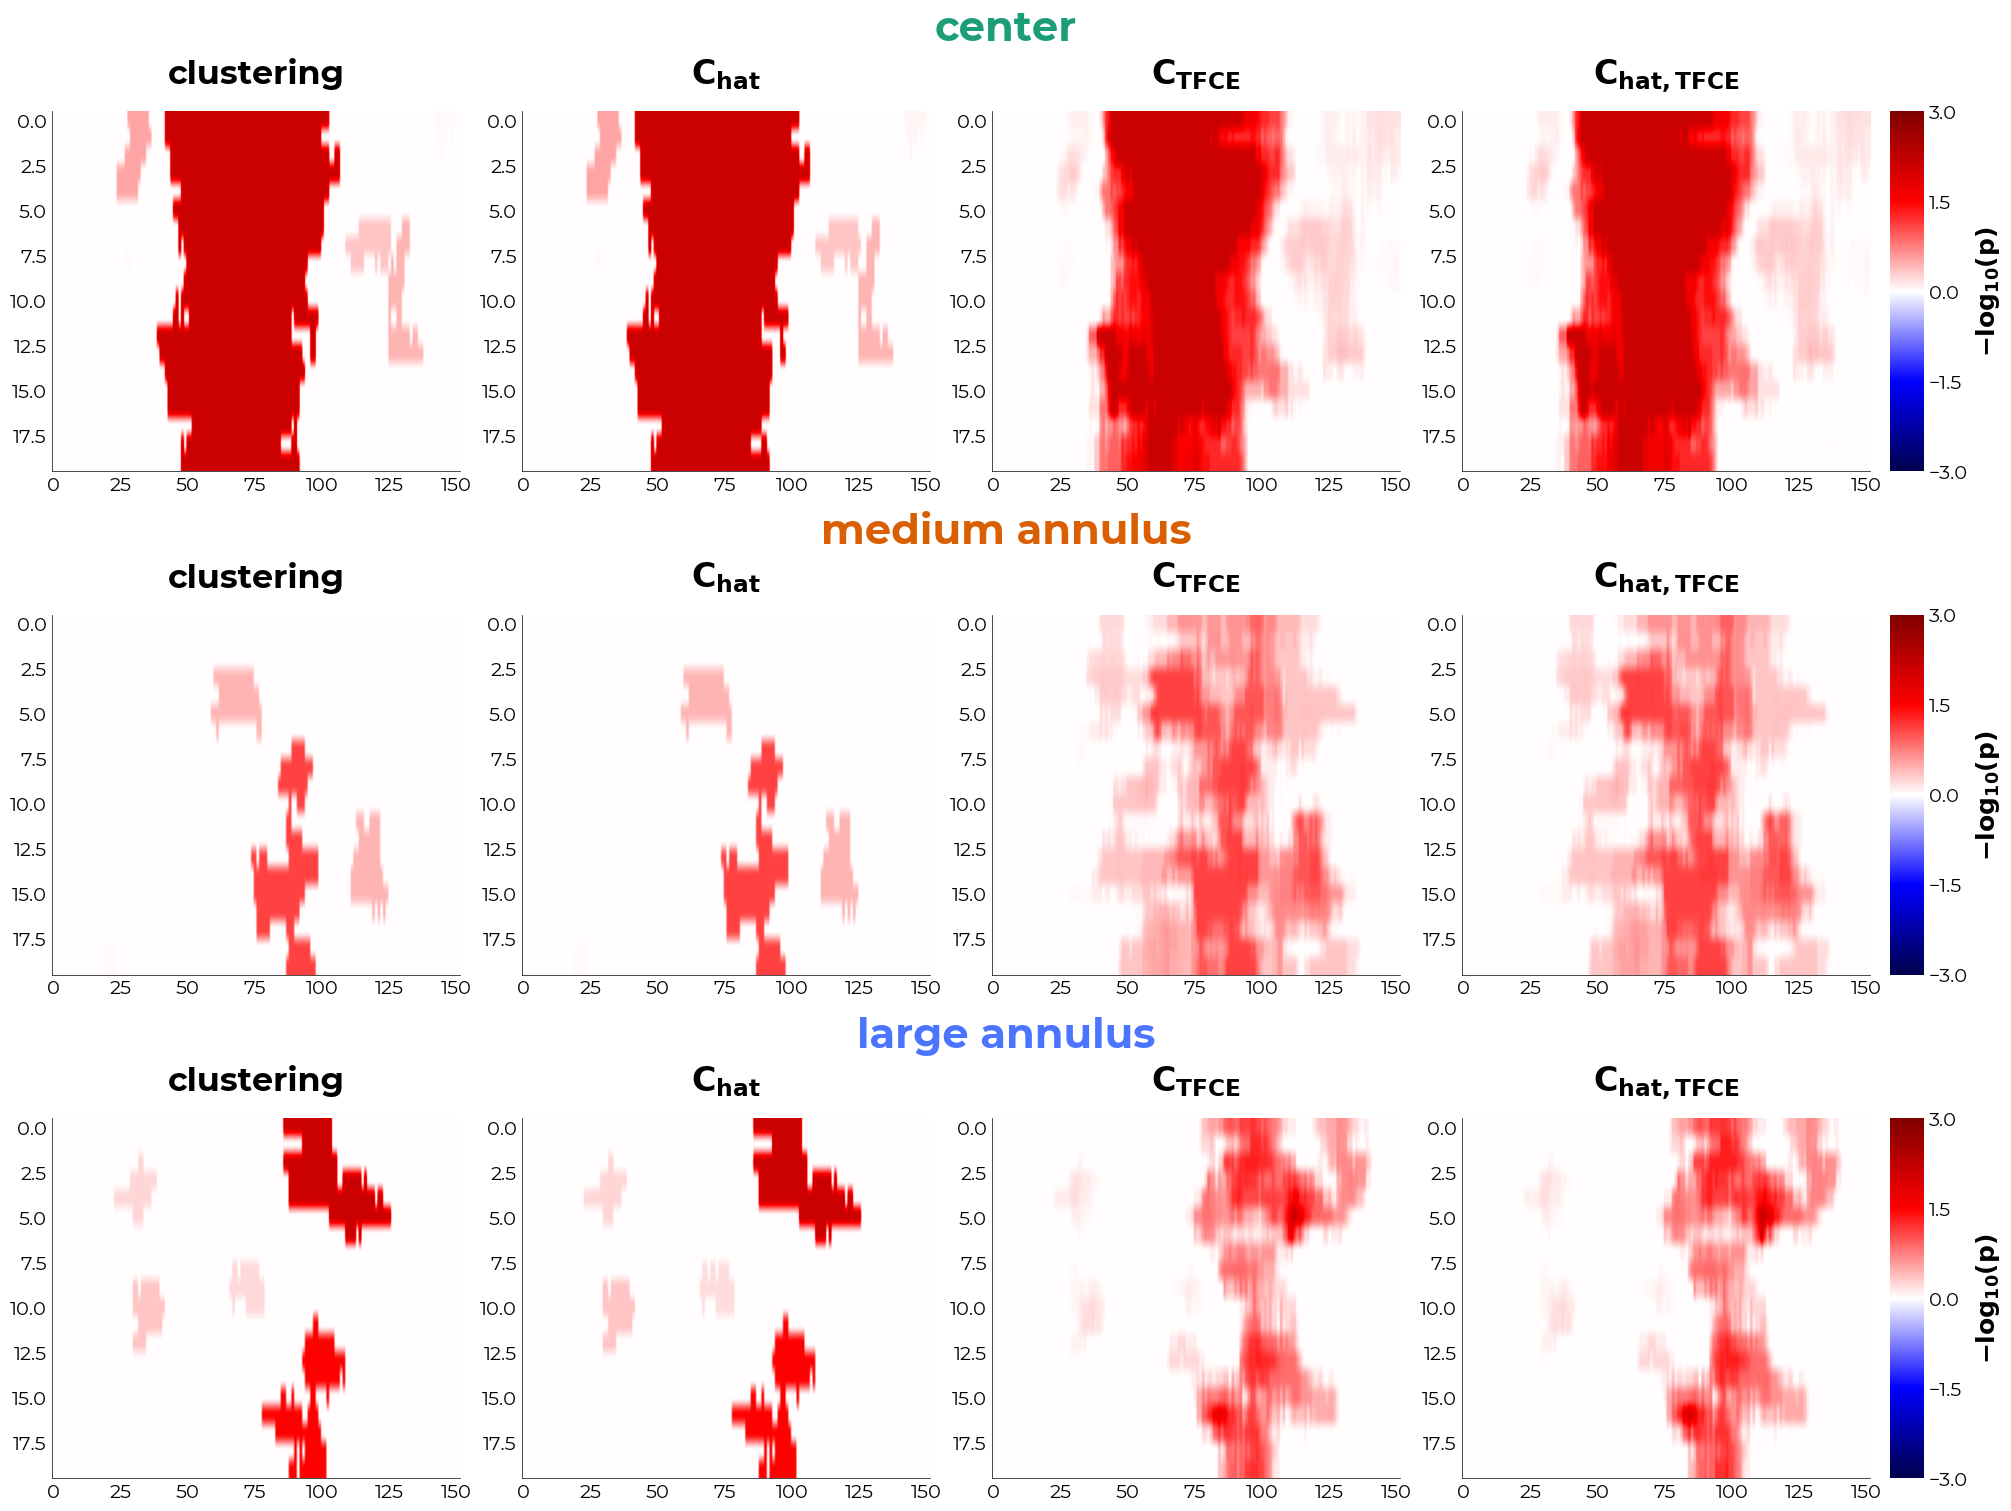

In [60]:
# Reshape data to what is equivalent to (n_samples, n_space, n_time)
from functools import partial
from scipy import stats
import mne
from mne.stats import (
    bonferroni_correction,
    fdr_correction,
    permutation_cluster_1samp_test,
    permutation_t_test,
    ttest_1samp_no_p,
)

subj_obj = hr.utils.SubjectsDict()


ev = "act"
evs = utils.get_unique_ids(sub_avg, id="event_type")

fig = plt.figure(figsize=(20,len(evs)*5), constrained_layout=True)
sfs = fig.subfigures(nrows=len(evs))

sub_avg = comp_excl.groupby(["subject","event_type","t"]).mean()
# evs = ["act"]
for ev_i, ev in enumerate(evs):
    ev_df = utils.select_from_df(sub_avg, expression=f"event_type = {ev}")

    sub_ids = utils.get_unique_ids(act_df, id="subject")
    arr = []
    for i in sub_ids:
        data = utils.select_from_df(ev_df, expression=f"subject = {i}").values.T[np.newaxis,...]
        arr.append(data)

    arr = np.concatenate(arr, axis=0)
    arr.shape

    n_subjects, depth, time = arr.shape
    n_permutations = 1000
    alpha = 0.05
    sigma = 1e-3  # sigma for the "hat" method

    # Compute threshold from t distribution (this is also the default)
    # Here we use a two-tailed test, hence we need to divide alpha by 2.
    # Subtracting alpha from 1 guarantees that we get a positive threshold,
    # which MNE-Python expects for two-tailed tests.
    df = n_subjects - 1  # degrees of freedom
    t_thresh = stats.distributions.t.ppf(1 - alpha / 2, df=df)


    cm = "seismic"
    mmax = {
        "cmap": cm,
        "vmin": -3,
        "vmax": 3
    }

    axs = sfs[ev_i].subplots(
        ncols=5, 
        width_ratios=[0.24,0.24,0.24,0.24,0.02],
    )


    # run the cluster test
    t_clust, clusters, p_values, H0 = permutation_cluster_1samp_test(
        arr,
        n_jobs=None,
        threshold=t_thresh,
        adjacency=None,
        n_permutations=n_permutations,
        out_type="mask",
    )

    # Put the cluster data in a viewable format
    p_clust = np.ones((depth, time))
    for cl, p in zip(clusters, p_values):
        p_clust[cl] = p

    ix = 0
    axs[ix].imshow(
        -np.log10(p_clust), 
        aspect="auto", 
        **mmax
    )

    plotting.conform_ax_to_obj(
        ax=axs[ix],
        title={
            "title": "clustering",
            "fontweight": "bold"
        }
    )

    threshold_tfce = dict(start=0, step=0.2)
    tail = 0
    stat_fun_hat = partial(ttest_1samp_no_p, sigma=sigma)
    t_hat, clusters, p_values, H0 = permutation_cluster_1samp_test(
        arr,
        n_jobs=None,
        threshold=t_thresh,
        adjacency=None,
        out_type="mask",
        n_permutations=n_permutations,
        stat_fun=stat_fun_hat,
        buffer_size=None,
    )

    p_hat = np.ones((depth,time))
    for cl, p in zip(clusters, p_values):
        p_hat[cl] = p

    ix += 1
    axs[ix].imshow(
        -np.log10(p_hat), 
        aspect="auto", 
        **mmax
    )

    plotting.conform_ax_to_obj(
        ax=axs[ix],
        title={
            "title": r"$\mathbf{C_{hat}}$",
            "fontweight": "bold"
        }
    )

    # threshold_tfce = dict(start=-10, step=0.2)
    t_tfce, _, p_tfce, H0 = permutation_cluster_1samp_test(
        arr,
        n_jobs=None,
        threshold=threshold_tfce,
        adjacency=None,
        n_permutations=n_permutations,
        out_type="mask",
        tail=tail
    )

    ix += 1
    axs[ix].imshow(
        -np.log10(p_tfce.reshape(depth,time)), 
        aspect="auto", 
        **mmax
    )

    plotting.conform_ax_to_obj(
        ax=axs[ix],
        title={
            "title": r"$\mathbf{C_{TFCE}}$",
            "fontweight": "bold"
        }
    )

    t_tfce_hat, _, p_tfce_hat, H0 = permutation_cluster_1samp_test(
        arr,
        n_jobs=None,
        threshold=threshold_tfce,
        adjacency=None,
        out_type="mask",
        n_permutations=n_permutations,
        stat_fun=stat_fun_hat,
        buffer_size=None,
        tail=tail
    )

    ix += 1
    axs[ix].imshow(
        -np.log10(p_tfce_hat.reshape(depth,time)),
        aspect="auto", 
        **mmax
    )

    plotting.conform_ax_to_obj(
        ax=axs[ix],
        title={
            "title": r"$\mathbf{C_{hat,TFCE}}$",
            "fontweight": "bold"
        }
    )

    plotting.LazyColorbar(
        axs=axs[-1],
        txt=r"$\mathbf{-log_{10}(p)}$",
        **mmax
    )

    sfs[ev_i].suptitle(
        subj_obj.get_evs()[ev_i], 
        fontsize=30, 
        fontweight="bold", 
        color=subj_obj.get_colors()[ev_i]
    )

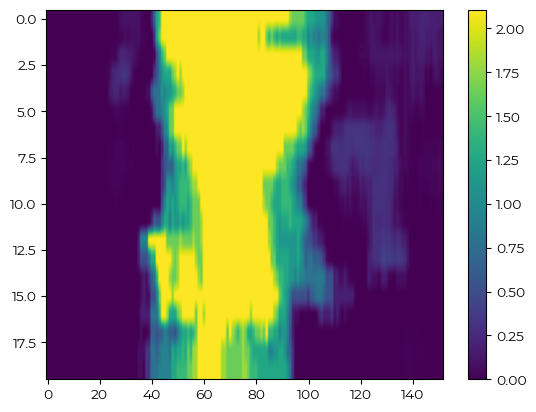

In [58]:
plt.imshow(-np.log10(p_tfce_hat.reshape(depth,time)), aspect="auto")
plt.colorbar()

In [97]:
t_tfce_hat, _, p_tfce_hat, H0 = permutation_cluster_1samp_test(
    arr,
    n_jobs=None,
    threshold=dict(start=0, step=0.2),
    adjacency=None,
    # out_type="mask",
    # n_permutations=n_permutations,
    # stat_fun=stat_fun_hat,
    buffer_size=None,
    tail=0
)

stat_fun(H1): min=-5.467193 max=7.767254
Running initial clustering …
Using 39 thresholds from 0.00 to 7.60 for TFCE computation (h_power=2.00, e_power=0.50)
Found 3040 clusters


  0%|          | Permuting (exact test) : 0/127 [00:00<?,       ?it/s]

In [98]:
print(mmax)

{'cmap': 'seismic', 'vmin': -3, 'vmax': 3}


In [99]:
arr.shape

(8, 20, 152)

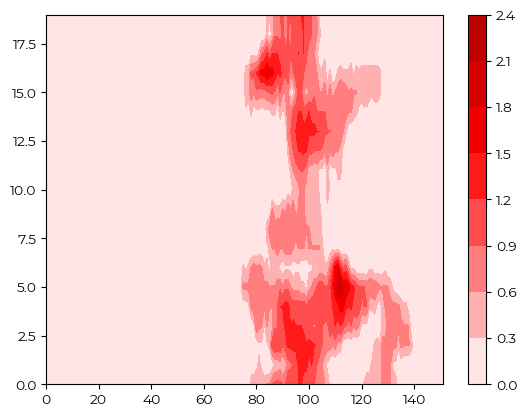

In [100]:
plt.contourf(
    -np.log10(p_tfce_hat.reshape(depth,time)),
    aspect="auto", 
    **mmax
)
plt.colorbar()